In [36]:
pip install MetaTrader5

Note: you may need to restart the kernel to use updated packages.


In [81]:
import datetime
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import time
import MetaTrader5 as mt5
import backtrader as bt
import pandas as pd
import numpy as np
import schedule
import matplotlib.pyplot as plt



In [82]:
#Connect to MT5
mt5.initialize()

True

In [83]:
login = 5033700289
password = "J_Yf0bLr"
server = "MetaQuotes-Demo"


In [84]:
mt5.login(login, password, server)

True

In [85]:
# Get account information
account_info = mt5.account_info()

print(f"Account Balance: ${account_info.balance:.2f}")

Account Balance: $785.90


In [86]:
account_info

AccountInfo(login=5033700289, trade_mode=0, leverage=500, limit_orders=200, margin_so_mode=0, trade_allowed=True, trade_expert=True, margin_mode=2, currency_digits=2, fifo_close=False, balance=785.9, credit=0.0, profit=0.0, equity=785.9, margin=0.0, margin_free=785.9, margin_level=0.0, margin_so_call=50.0, margin_so_so=30.0, margin_initial=0.0, margin_maintenance=0.0, assets=0.0, liabilities=0.0, commission_blocked=0.0, name='Chukwunonso Nnodum', server='MetaQuotes-Demo', currency='USD', company='MetaQuotes Ltd.')

In [87]:
#Importing Financial Data

symbol = "GBPUSD"
rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M5, 0, 70000)  # Fetch more historical data
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# Display the last few rows
df.tail()


# In[31]:


# Transforming and Cleaning the data
df_cleaned = df.drop(columns=["real_volume", "spread", "tick_volume"])

# Display the first few rows
df_cleaned.head()


,time,open,high,low,close
0,2024-03-26 14:15:00,1.26555,1.26556,1.26494,1.26496
1,2024-03-26 14:20:00,1.26492,1.26492,1.26416,1.26436
2,2024-03-26 14:25:00,1.26436,1.26448,1.26422,1.26429
3,2024-03-26 14:30:00,1.26429,1.26458,1.26395,1.26424
4,2024-03-26 14:35:00,1.26419,1.26488,1.26408,1.26486


In [88]:
# Convert 'time' column to datetime if not already done
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'])

# Filter for today's data
today = df_cleaned['time'].dt.date.max()  # Get the latest available date
df_today = df_cleaned[df_cleaned['time'].dt.date == today]

df_today
# use df_today to get todays numbers

,time,open,high,low,close
69890,2025-03-05 00:00:00,1.27841,1.27929,1.27841,1.27901
69891,2025-03-05 00:05:00,1.27901,1.27901,1.27879,1.27893
69892,2025-03-05 00:10:00,1.27892,1.27912,1.27865,1.27865
69893,2025-03-05 00:15:00,1.27866,1.27909,1.27866,1.27891
69894,2025-03-05 00:20:00,1.27892,1.27908,1.27868,1.27889
...,...,...,...,...,...
69995,2025-03-05 08:45:00,1.27874,1.27915,1.27871,1.27898
69996,2025-03-05 08:50:00,1.27898,1.27936,1.27883,1.27934
69997,2025-03-05 08:55:00,1.27938,1.27980,1.27930,1.27966
69998,2025-03-05 09:00:00,1.27971,1.28078,1.27971,1.28077


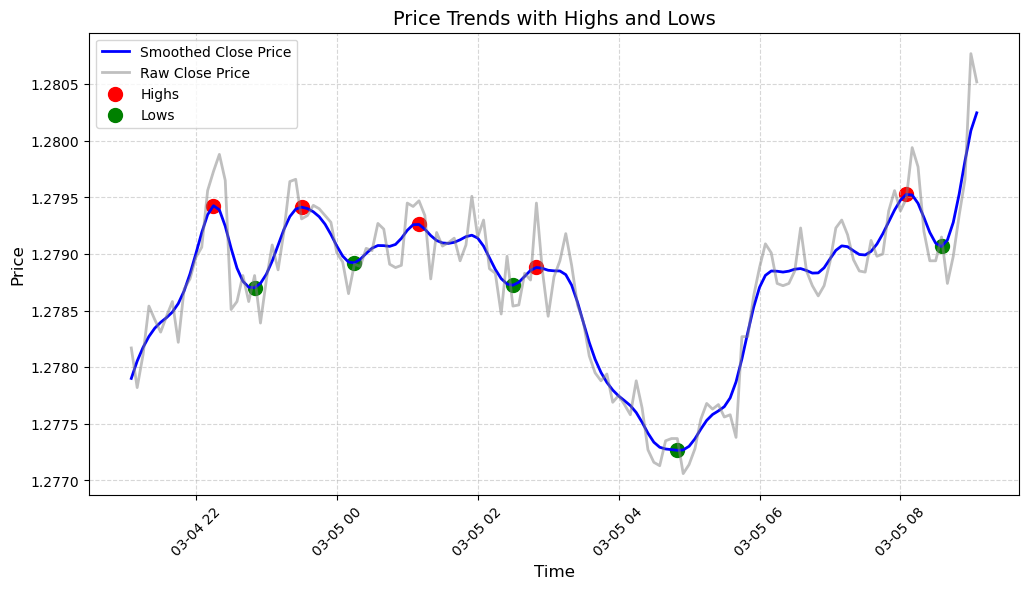

In [89]:
#detecting trends


# Ensure 'time' is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Apply smoothing to reduce noise in trend detection
df['close_smooth'] = gaussian_filter1d(df['close'], sigma=2)

# Detect Peaks (Higher Highs) and Troughs (Lower Lows)
peaks_idx, _ = find_peaks(df['close_smooth'], distance=15, prominence=0.0001)
troughs_idx, _ = find_peaks(-df['close_smooth'], distance=15, prominence=0.0001)

# Extract Highs and Lows
df['Highs'] = np.nan
df['Lows'] = np.nan

# Assign peak and trough values
df.loc[peaks_idx, 'Highs'] = df['close_smooth'].iloc[peaks_idx]  # Red markers (Highs)
df.loc[troughs_idx, 'Lows'] = df['close_smooth'].iloc[troughs_idx]  # Green markers (Lows)

# Filter last 6 hours for visualization
df_last_six_hours = df[df['time'] >= df['time'].max() - pd.Timedelta(hours=12)]

# Plot price action with detected trends
plt.figure(figsize=(12,6))
plt.plot(df_last_six_hours['time'], df_last_six_hours['close_smooth'], color='blue', linewidth=2, label="Smoothed Close Price")
plt.plot(df_last_six_hours['time'], df_last_six_hours['close'], color='gray', alpha=0.5, linewidth=2, label="Raw Close Price")

# Plot Highs (Red Markers)
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Highs'], color='red', marker='o', s=100, label="Highs")

# Plot Lows (Green Markers)
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Lows'], color='green', marker='o', s=100, label="Lows")

# Formatting
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.title("Price Trends with Highs and Lows", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


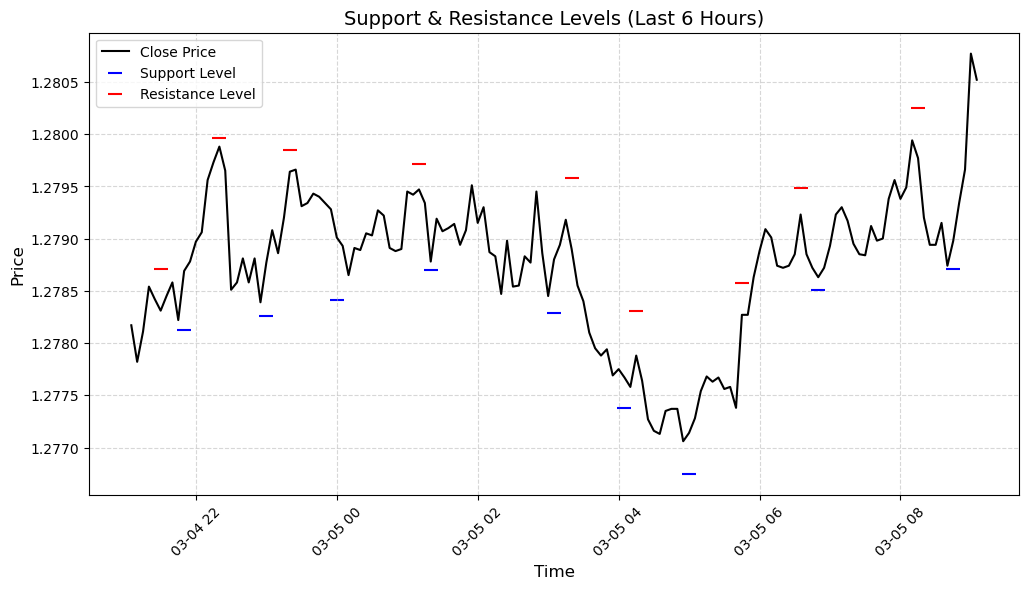

In [90]:
#Detecting Support and Resistance levels


# Ensure 'time' is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Function to detect support and resistance using peaks
def detect_support_resistance(df):
    # Find peaks for Resistance (Highs) and Support (Lows)
    resistance_idx, _ = find_peaks(df['high'], distance=10, prominence=0.0001)
    support_idx, _ = find_peaks(-df['low'], distance=10, prominence=0.0001)

    # Assign detected support and resistance levels
    df['Support'] = np.nan
    df['Resistance'] = np.nan
    df.loc[support_idx, 'Support'] = df['low'].iloc[support_idx]  # Support levels
    df.loc[resistance_idx, 'Resistance'] = df['high'].iloc[resistance_idx]  # Resistance levels

    return df

# Apply support & resistance detection
df = detect_support_resistance(df)

# Filter last 6 hours of data for visualization
df_last_six_hours = df[df['time'] >= df['time'].max() - pd.Timedelta(hours=12)]

# Plot Support & Resistance
plt.figure(figsize=(12,6))
plt.plot(df_last_six_hours['time'], df_last_six_hours['close'], color='black', linewidth=1.5, label="Close Price")

# Plot Support Levels (Blue markers)
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Support'], color='blue', marker='_', s=100, label="Support Level")

# Plot Resistance Levels (Red markers)
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Resistance'], color='red', marker='_', s=100, label="Resistance Level")

# Formatting
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.title("Support & Resistance Levels (Last 6 Hours)", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


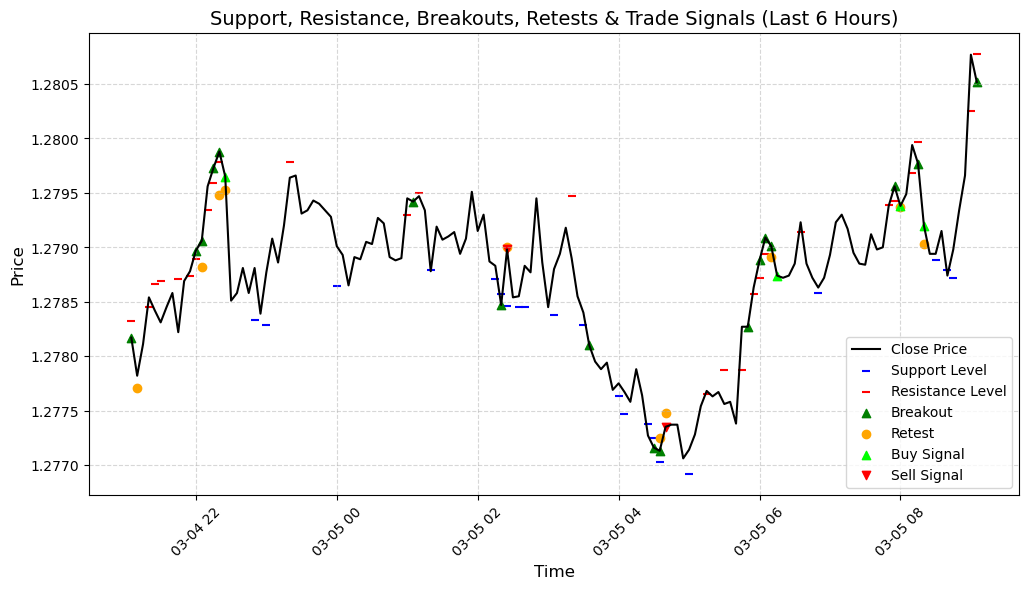

In [91]:
#Backtesting to Detecting Breakouts, Retests and key entry points into trades
# Ensure 'time' is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Function to detect support and resistance levels
def detect_support_resistance(df, window=10):
    df['Support'] = np.nan
    df['Resistance'] = np.nan
    
    for i in range(window, len(df)):
        local_min = df['low'][i-window:i].min()
        local_max = df['high'][i-window:i].max()
        
        if df['low'][i] <= local_min:
            df.at[i, 'Support'] = local_min
        if df['high'][i] >= local_max:
            df.at[i, 'Resistance'] = local_max
    
    return df

# Function to detect breakouts and retests
def detect_breakout_retest(df):
    df['Breakout'] = np.nan
    df['Retest'] = np.nan
    
    for i in range(1, len(df)):
        if pd.notna(df.at[i-1, 'Resistance']) and df['close'][i] > df.at[i-1, 'Resistance']:
            df.at[i, 'Breakout'] = df['close'][i]
        elif pd.notna(df.at[i-1, 'Support']) and df['close'][i] < df.at[i-1, 'Support']:
            df.at[i, 'Breakout'] = df['close'][i]
        
        if pd.notna(df.at[i-1, 'Breakout']) and df['low'][i] <= df.at[i-1, 'Resistance']:
            df.at[i, 'Retest'] = df['low'][i]
        elif pd.notna(df.at[i-1, 'Breakout']) and df['high'][i] >= df.at[i-1, 'Support']:
            df.at[i, 'Retest'] = df['high'][i]
    
    return df

# Function to detect trade entries
def detect_trade_signals(df):
    df['Buy_Signal'] = np.nan
    df['Sell_Signal'] = np.nan

    for i in range(2, len(df)):
        # **Buy Signal:** Price breaks resistance, retests it, and moves higher
        if pd.notna(df.at[i-2, 'Resistance']) and df['close'][i-1] > df.at[i-2, 'Resistance']:  # Breakout confirmation
            if df['low'][i] <= df.at[i-2, 'Resistance']:  # Retest condition
                df.at[i, 'Buy_Signal'] = df['close'][i]

        # **Sell Signal:** Price breaks support, retests it, and moves lower
        if pd.notna(df.at[i-2, 'Support']) and df['close'][i-1] < df.at[i-2, 'Support']:  # Breakout confirmation
            if df['high'][i] >= df.at[i-2, 'Support']:  # Retest condition
                df.at[i, 'Sell_Signal'] = df['close'][i]

    return df

# Apply detection functions
df = detect_support_resistance(df, window=10)
df = detect_breakout_retest(df)
df = detect_trade_signals(df)


# Filter last 6 hours for visualization
df_last_six_hours = df[df['time'] >= df['time'].max() - pd.Timedelta(hours=12)]

# Plot Price Action
plt.figure(figsize=(12,6))
plt.plot(df_last_six_hours['time'], df_last_six_hours['close'], color='black', linewidth=1.5, label="Close Price")

# Plot Support & Resistance
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Support'], color='blue', marker='_', label="Support Level")
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Resistance'], color='red', marker='_', label="Resistance Level")

# Plot Breakouts & Retests
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Breakout'], color='green', marker='^', label="Breakout")
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Retest'], color='orange', marker='o', label="Retest")

# Plot Buy & Sell Signals
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Buy_Signal'], color='lime', marker='^', label="Buy Signal")
plt.scatter(df_last_six_hours['time'], df_last_six_hours['Sell_Signal'], color='red', marker='v', label="Sell Signal")

# Formatting
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.title("Support, Resistance, Breakouts, Retests & Trade Signals (Last 6 Hours)", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


In [92]:
#calculating the total number of trades taken
# Apply functions
df = detect_support_resistance(df, window=10)
df = detect_breakout_retest(df)
df = detect_trade_signals(df)

# **Filter last 24 hours for trade counting**
df_last_24_hours = df[df['time'] >= df['time'].max() - pd.Timedelta(hours=72)]

# **Count the total number of trades in the last 24 hours**
total_buy_trades = df_last_24_hours['Buy_Signal'].count()
total_sell_trades = df_last_24_hours['Sell_Signal'].count()
total_trades = total_buy_trades + total_sell_trades

# **Print results**
print(f"Total Buy Trades in 24 Hours: {total_buy_trades}")
print(f"Total Sell Trades in 24 Hours: {total_sell_trades}")
print(f"Total Trades in 24 Hours: {total_trades}")


Total Buy Trades in 24 Hours: 32
Total Sell Trades in 24 Hours: 20
Total Trades in 24 Hours: 52


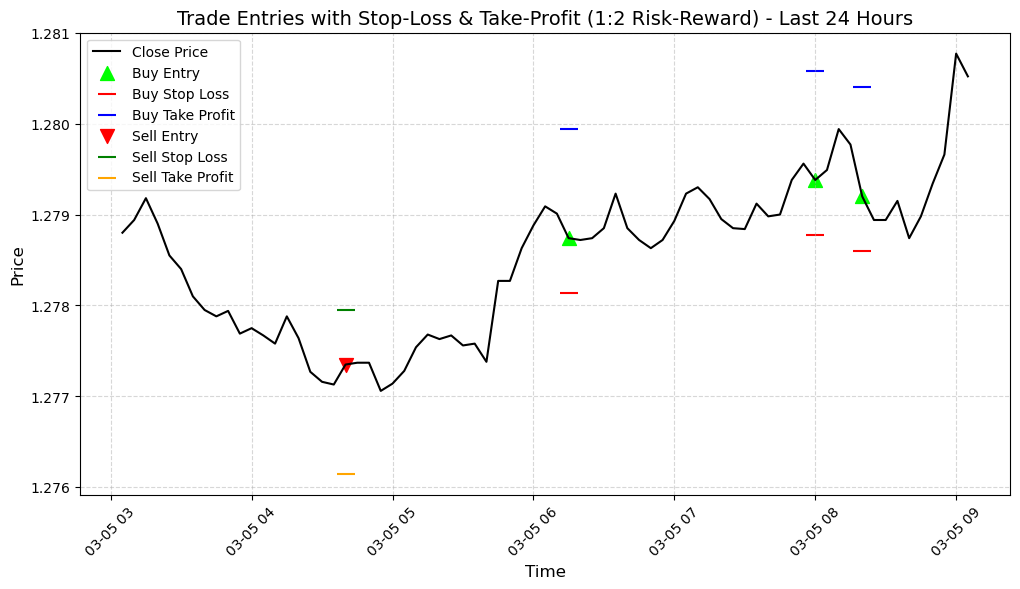

In [93]:
#adding stoploss and takeprofit to trades taken


# Drop existing 'Breakeven_Level' column if it already exists to prevent duplicates
if 'Breakeven_Level' in df.columns:
    df.drop(columns=['Breakeven_Level'], inplace=True)

if 'Stop_Loss' not in df.columns:
    df['Stop_Loss'] = np.nan  # Initialize with NaN to prevent KeyErrors

if 'Take_Profit' not in df.columns:
    df['Take_Profit'] = np.nan  # Initialize with NaN to prevent KeyErrors

# Ensure 'time' is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Filter last 24 hours for visualization
df_last_24_hours = df[df['time'] >= df['time'].max() - pd.Timedelta(hours=6)]

# Extract Buy and Sell Signals
buy_signals = df_last_24_hours.dropna(subset=['Buy_Signal']).copy()
sell_signals = df_last_24_hours.dropna(subset=['Sell_Signal']).copy()

# Define pip size (Assuming Forex trading with 5 decimal places)
pip_size = 0.0001  # Example: For EUR/USD, 1 pip = 0.0001

# **Calculate Stop-Loss & Take-Profit**
buy_signals['Stop_Loss'] = buy_signals['Buy_Signal'] - (6 * pip_size)
buy_signals['Take_Profit'] = buy_signals['Buy_Signal'] + (12 * pip_size)
buy_signals['Breakeven_Level_Buy'] = buy_signals['Buy_Signal'] + (6 * pip_size)

sell_signals['Stop_Loss'] = sell_signals['Sell_Signal'] + (6 * pip_size)
sell_signals['Take_Profit'] = sell_signals['Sell_Signal'] - (12 * pip_size)
sell_signals['Breakeven_Level_Sell'] = sell_signals['Sell_Signal'] - (6 * pip_size)

# Merge Breakeven_Level back into df so it's available for all calculations
df = df.merge(buy_signals[['time', 'Breakeven_Level_Buy']], on='time', how='left')
df = df.merge(sell_signals[['time', 'Breakeven_Level_Sell']], on='time', how='left')

# Combine Buy and Sell Breakeven Levels into a single column
df['Breakeven_Level'] = df[['Breakeven_Level_Buy', 'Breakeven_Level_Sell']].max(axis=1)

# Drop intermediate columns
df.drop(columns=['Breakeven_Level_Buy', 'Breakeven_Level_Sell'], inplace=True)

# Fill missing values to prevent errors
df['Breakeven_Level'].fillna(0, inplace=True)  # Prevents missing values
df['Stop_Loss'].fillna(0, inplace=True)
df['Take_Profit'].fillna(0, inplace=True)

# **Plot Price Action**
plt.figure(figsize=(12,6))
plt.plot(df_last_24_hours['time'], df_last_24_hours['close'], color='black', linewidth=1.5, label="Close Price")

# **Plot Buy Trades**
plt.scatter(buy_signals['time'], buy_signals['Buy_Signal'], color='lime', marker='^', s=100, label="Buy Entry")
plt.scatter(buy_signals['time'], buy_signals['Stop_Loss'], color='red', marker='_', s=150, label="Buy Stop Loss")
plt.scatter(buy_signals['time'], buy_signals['Take_Profit'], color='blue', marker='_', s=150, label="Buy Take Profit")

# **Plot Sell Trades**
plt.scatter(sell_signals['time'], sell_signals['Sell_Signal'], color='red', marker='v', s=100, label="Sell Entry")
plt.scatter(sell_signals['time'], sell_signals['Stop_Loss'], color='green', marker='_', s=150, label="Sell Stop Loss")
plt.scatter(sell_signals['time'], sell_signals['Take_Profit'], color='orange', marker='_', s=150, label="Sell Take Profit")

# Formatting
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.title("Trade Entries with Stop-Loss & Take-Profit (1:2 Risk-Reward) - Last 24 Hours", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


Starting Balance: $1001.02
Lot Size per Trade: 0.167 Lots
Total Buy Trades: 4 | Wins: 2 | Losses: 1 | Breakevens: 1
Total Sell Trades: 2 | Wins: 0 | Losses: 0 | Breakevens: 2
Total Trades: 6
Winning Trades: 2 | Losing Trades: 1 | Breakeven Trades: 3
Win Rate: 33.33%
Total Profit/Loss: $30.00
Final Account Balance: $1031.02


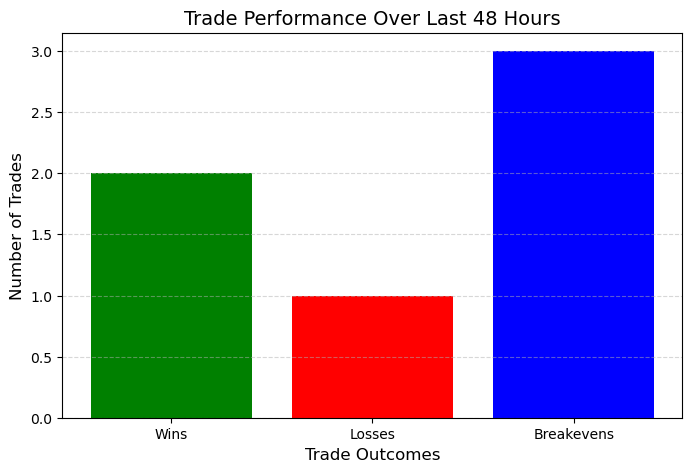

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'time' is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Trading Parameters
starting_balance = 1001.02  # USD
risk_per_trade = 10  # USD risk per trade
stop_loss_pips = 6  # 6 pips SL
take_profit_pips = 12  # 12 pips TP
pip_value_per_standard_lot = 10  # $10 per pip per standard lot

# Function to calculate lot size
def calculate_lot_size(risk_amount, stop_loss_pips, pip_value_per_standard_lot):
    return risk_amount / (stop_loss_pips * pip_value_per_standard_lot)

lot_size = calculate_lot_size(risk_per_trade, stop_loss_pips, pip_value_per_standard_lot)

# Filter last 48 hours for analysis
df_last_48_hours = df[df['time'] >= df['time'].max() - pd.Timedelta(hours=12)]

# Extract Buy & Sell signals
buy_signals = df_last_48_hours.dropna(subset=['Buy_Signal']).copy()
sell_signals = df_last_48_hours.dropna(subset=['Sell_Signal']).copy()

pip_size = 0.0001  # Define pip size

# Set Stop-Loss, Take-Profit, and Breakeven Levels
buy_signals['Stop_Loss'] = buy_signals['Buy_Signal'] - (stop_loss_pips * pip_size)
buy_signals['Take_Profit'] = buy_signals['Buy_Signal'] + (take_profit_pips * pip_size)
buy_signals['Breakeven_Level'] = buy_signals['Buy_Signal'] + (6 * pip_size)

sell_signals['Stop_Loss'] = sell_signals['Sell_Signal'] + (stop_loss_pips * pip_size)
sell_signals['Take_Profit'] = sell_signals['Sell_Signal'] - (take_profit_pips * pip_size)
sell_signals['Breakeven_Level'] = sell_signals['Sell_Signal'] - (6 * pip_size)

# Initialize Counters
buy_wins = buy_losses = buy_breakevens = 0
sell_wins = sell_losses = sell_breakevens = 0
profit_from_trades = 0

# Function to evaluate trade outcomes
def evaluate_trades(signals, trade_type):
    global buy_wins, buy_losses, buy_breakevens, sell_wins, sell_losses, sell_breakevens, profit_from_trades
    
    for index, row in signals.iterrows():
        future_prices = df_last_48_hours[df_last_48_hours['time'] > row['time']]
        if future_prices.empty:
            continue
        
        hit_tp = future_prices[future_prices['high'] >= row['Take_Profit']].head(1) if trade_type == 'Buy' else future_prices[future_prices['low'] <= row['Take_Profit']].head(1)
        hit_sl = future_prices[future_prices['low'] <= row['Stop_Loss']].head(1) if trade_type == 'Buy' else future_prices[future_prices['high'] >= row['Stop_Loss']].head(1)
        hit_be = future_prices[future_prices['high'] >= row['Breakeven_Level']].head(1) if trade_type == 'Buy' else future_prices[future_prices['low'] <= row['Breakeven_Level']].head(1)

        if not hit_tp.empty and (hit_sl.empty or hit_tp.iloc[0]['time'] < hit_sl.iloc[0]['time']):
            if trade_type == 'Buy':
                buy_wins += 1
            else:
                sell_wins += 1
            profit_from_trades += (take_profit_pips * pip_value_per_standard_lot * lot_size)
        elif not hit_be.empty and (hit_sl.empty or hit_be.iloc[0]['time'] < hit_sl.iloc[0]['time']):
            if trade_type == 'Buy':
                buy_breakevens += 1
            else:
                sell_breakevens += 1
        elif not hit_sl.empty:
            if trade_type == 'Buy':
                buy_losses += 1
            else:
                sell_losses += 1
            profit_from_trades -= (stop_loss_pips * pip_value_per_standard_lot * lot_size)

# Evaluate Buy & Sell Trades
evaluate_trades(buy_signals, 'Buy')
evaluate_trades(sell_signals, 'Sell')

# Performance Metrics
total_wins = buy_wins + sell_wins
total_losses = buy_losses + sell_losses
total_breakevens = buy_breakevens + sell_breakevens
total_trades = total_wins + total_losses + total_breakevens
win_rate = (total_wins / total_trades) * 100 if total_trades > 0 else 0
final_balance = starting_balance + profit_from_trades

# Print Results
print(f"Starting Balance: ${starting_balance:.2f}")
print(f"Lot Size per Trade: {lot_size:.3f} Lots")
print(f"Total Buy Trades: {len(buy_signals)} | Wins: {buy_wins} | Losses: {buy_losses} | Breakevens: {buy_breakevens}")
print(f"Total Sell Trades: {len(sell_signals)} | Wins: {sell_wins} | Losses: {sell_losses} | Breakevens: {sell_breakevens}")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {total_wins} | Losing Trades: {total_losses} | Breakeven Trades: {total_breakevens}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total Profit/Loss: ${profit_from_trades:.2f}")
print(f"Final Account Balance: ${final_balance:.2f}")

# Visualize Trade Performance
labels = ['Wins', 'Losses', 'Breakevens']
counts = [total_wins, total_losses, total_breakevens]
colors = ['green', 'red', 'blue']

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=colors)
plt.xlabel("Trade Outcomes", fontsize=12)
plt.ylabel("Number of Trades", fontsize=12)
plt.title("Trade Performance Over Last 48 Hours", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [95]:
import MetaTrader5 as mt5
#Connect to MT5
mt5.initialize()

login = 5033700289
password = "J_Yf0bLr"
server = "MetaQuotes-Demo"

mt5.login(login, password, server)

# Trading Bot Configuration
ticker = 'GBPUSD'
pip_size = 0.0001  # 1 pip for GBPUSD
qty = 0.16  # Lot Size

buy_order_type = mt5.ORDER_TYPE_BUY
sell_order_type = mt5.ORDER_TYPE_SELL

buy_price = mt5.symbol_info_tick("GBPUSD").ask
sell_price = mt5.symbol_info_tick("GBPUSD").bid

# Dictionaries
buy_signals = {'Buy_Signal': buy_price}
sell_signals = {'Sell_Signal': sell_price}

# Stop-Loss & Take-Profit for Buy Trades
buy_sl = buy_signals['Buy_Signal'] - (6 * pip_size)  # 6-pip SL
buy_tp = buy_signals['Buy_Signal'] + (12 * pip_size)  # 12-pip TP

# Stop-Loss & Take-Profit for Sell Trades
sell_sl = sell_signals['Sell_Signal'] + (6 * pip_size)  # 6-pip SL
sell_tp = sell_signals['Sell_Signal'] - (12 * pip_size)  # 12-pip TP


# Function to Create Either Buy or Sell Orders
def create_order(ticker, qty, order_type, price, sl, tp):
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": ticker,
        "volume": qty,
        "type": order_type,
        "price": price,
        "sl": sl,
        "tp": tp,
        "comment": "Python open position",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC
    }
    
    # Send the trading request
    order = mt5.order_send(request)
    
    if order and order.retcode == mt5.TRADE_RETCODE_DONE:
        print(f"Order placed successfully: Ticket {order.order}")
        return order.order  # Return the trade ID
    else:
        print(f"Order failed: {order.comment if order else 'No response from server'}")
        return None


# Function for Closing Buy or Sell Orders
def close_order(ticker, qty, order_type, price):
    positions = mt5.positions_get(symbol=ticker)  # Get open positions for this ticker
    
    if positions:  # If there is an open trade
        position_id = positions[0]._asdict()['ticket']  # Get first open position's ticket
        
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": ticker,
            "volume": qty,
            "type": order_type,
            "price": price,
            "position": position_id,
            "comment": "Closing trade",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC
        }

        # Send the trading request
        order = mt5.order_send(request)
        
        if order and order.retcode == mt5.TRADE_RETCODE_DONE:
            print(f"Position {position_id} closed successfully")
        else:
            print(f"Failed to close position {position_id}: {order.comment if order else 'No response from server'}")
    else:
        print(f"No open positions to close for {ticker}")


In [ ]:
import time

#TRADINGBOT
#Pine Script

while True:
    symbol = "GBPUSD"
    rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M5, 0, 1000)  # Fetch more historical data
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
        # Apply detection functions
    df = detect_support_resistance(df, window=10)
    df = detect_breakout_retest(df)
    df = detect_trade_signals(df)
    
    # Ensure 'Stop_Loss' & 'Take_Profit' exist before using them
    if 'Stop_Loss' not in df.columns:
        df['Stop_Loss'] = np.nan  
    if 'Take_Profit' not in df.columns:
        df['Take_Profit'] = np.nan 
    
    df['Stop_Loss'].fillna(0, inplace=True)
    df['Take_Profit'].fillna(0, inplace=True)


    long_condition = (
        pd.notna(df['Resistance'].shift(2)).any()  # Resistance exists 2 candles ago
        and (df['close'].shift(1) > df['Resistance'].shift(2)).any()  # Breakout confirmed
        and (df['low'] <= df['Resistance'].shift(2)).any()  # Retest confirmation
    )
    short_condition = (
        pd.notna(df['Support'].shift(2)).any()  # Support exists 2 candles ago
        and (df['close'].shift(1) < df['Support'].shift(2)).any()  # Breakout confirmed
        and (df['high'] >= df['Support'].shift(2)).any()  # Retest confirmation
    )
    close_long_condition = (
        (df['close'] <= df['Stop_Loss']).any() |  # Stop-loss reached
        (df['close'] >= df['Take_Profit']).any()  # Take-profit reached
    )
    close_short_condition = (
        (df['close'] >= df['Stop_Loss']).any() |  # Stop-loss reached for short
        (df['close'] <= df['Take_Profit']).any()  # Take-profit reached for short
    )
    
    # Ensure 'Breakeven_Level' exists before using it
    if 'Breakeven_Level' not in df.columns:
        df['Breakeven_Level'] = np.nan  # Initialize with NaN to prevent KeyErrors

    # Fill missing Breakeven Levels with 0
    df['Breakeven_Level'].fillna(0, inplace=True)
    
    breakeven_buy_condition = (
        df['high'] >= df['Breakeven_Level']
    ).any()
    breakeven_sell_condition = (
        df['low'] <= df['Breakeven_Level']
    ).any()
    
    already_buy = False
    already_sell = False
    
    try:
        already_sell = mt5.positions_get()[0]._asdict()['type'] == 1
        already_buy = mt5.positions_get()[0]._asdict()['type'] == 0
    except:
        pass
    
    no_positions = len(mt5.positions_get()) == 0
    
    # 🟢 RECORD TRADE OPEN TIME HERE
    trade_open_time = None

    #Implementing conditions for longs and shorts
    if long_condition:
        if no_positions:
            create_order(ticker, qty, buy_order_type, buy_price, buy_sl, buy_tp)
            print('Buy Order Placed')
            trade_open_time = time.time()  # Track when trade opens ✅
        if already_sell:
            close_order(ticker, qty, buy_order_type, buy_price)
            print('Sell Position Closed')
            time.sleep(1)
            create_order(ticker, qty, buy_order_type, buy_price, buy_sl, buy_tp)
            print('Buy Order Placed')
            trade_open_time = time.time()  # Track when trade opens ✅

    if short_condition:
        if no_positions:
            create_order(ticker, qty, sell_order_type, sell_price, sell_sl, sell_tp)
            print('Sell Order Placed')
            trade_open_time = time.time()  # Track when trade opens ✅
        if already_buy:
            close_order(ticker, qty, sell_order_type, sell_price)
            print('Buy Position Closed')
            time.sleep(1)
            create_order(ticker, qty, sell_order_type, sell_price, sell_sl, buy_tp)
            print('Sell Order Placed')
            trade_open_time = time.time()  # Track when trade opens ✅
    
    try:
        already_sell = mt5.positions_get()[0]._asdict()['type'] == 1
        already_buy = mt5.positions_get()[0]._asdict()['type'] == 0
    except:
        pass
    # 🟢 CHECK EXIT CONDITIONS ONLY AFTER HOLDING FOR 60 SECONDS ✅
    if trade_open_time and time.time() - trade_open_time > 60:
        if close_long_condition and already_buy:
            close_order(ticker, qty, sell_order_type, sell_price)
            print('Closed Buy Position')

        if close_short_condition and already_sell:
            close_order(ticker, qty, buy_order_type, buy_price)
            print('Closed Sell Position') 
    
    already_buy = False
    already_sell = False
    
    #Implementing condition for breakeven
    # Initialize hit_be before using it
    hit_be = pd.DataFrame()  # Ensures it's always defined

    # Implementing condition for breakeven
    if not hit_be.empty and (hit_sl.empty or hit_be.iloc[0]['time'] < hit_sl.iloc[0]['time']):
        if trade_type == 'Buy':
            buy_breakevens += 1
        else:
            sell_breakevens += 1
    
    time.sleep(10)
    


Order failed: Requote
Buy Order Placed
Order failed: Requote
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed: Requote
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: Requote
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed: No prices
Buy Order Placed
Order failed: No prices
Sell Order Placed
Order failed

In [199]:
#placing BUY trade

In [201]:
symbol = "GBPUSD"

request={
    "action": mt5.TRADE_ACTION_DEAL,
    "symbol": symbol,
    "volume": 0.01,
    "type": mt5.ORDER_TYPE_BUY,
    "price": mt5.symbol_info_tick(symbol).ask,
    "sl": 1.26440,
    "tp": 1.26720,
    "comment": "python script buy",
    "type_time": mt5.ORDER_TIME_GTC,
    "type_filling": mt5.ORDER_FILLING_IOC
}
# send a trading request
result=mt5.order_send(request)

In [176]:
result

OrderSendResult(retcode=10009, deal=3334145093, order=3375577253, volume=0.01, price=1.2664900000000001, bid=1.26621, ask=1.2664900000000001, comment='Request executed', request_id=404341991, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='GBPUSD', volume=0.01, price=1.2664900000000001, stoplimit=0.0, sl=1.2656, tp=1.2674, deviation=0, type=0, type_filling=1, type_time=0, expiration=0, comment='python script buy', position=0, position_by=0))

In [ ]:
#Placing SELL trade

In [41]:
symbol = "GBPUSD"

request={
    "action": mt5.TRADE_ACTION_DEAL,
    "symbol": symbol,
    "volume": 0.01,
    "type": mt5.ORDER_TYPE_SELL,
    "price": mt5.symbol_info_tick(symbol).bid,
    "sl": 1.26270,
    "tp": 1.26030,
    "comment": "python script sell",
    "type_time": mt5.ORDER_TIME_GTC,
    "type_filling": mt5.ORDER_FILLING_IOC
}
# send a trading request
result1=mt5.order_send(request)

In [42]:
result1

OrderSendResult(retcode=10009, deal=3321164221, order=3362239526, volume=0.01, price=1.26136, bid=1.26136, ask=1.26142, comment='Request executed', request_id=1231878160, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='GBPUSD', volume=0.01, price=1.26136, stoplimit=0.0, sl=1.2627, tp=1.2603, deviation=0, type=1, type_filling=1, type_time=0, expiration=0, comment='python script sell', position=0, position_by=0))

In [43]:
#closing BUY trade

In [47]:
symbol = "GBPUSD"

request={
    "action": mt5.TRADE_ACTION_DEAL,
    "symbol": symbol,
    "volume": 0.01,
    "type": mt5.ORDER_TYPE_SELL,
    "position": 3362231927,
    "price": mt5.symbol_info_tick(symbol).bid,
    "comment": "close buy position",
    "type_time": mt5.ORDER_TIME_GTC,
    "type_filling": mt5.ORDER_FILLING_IOC
}
# send a trading request
order =mt5.order_send(request)
print(order)

OrderSendResult(retcode=10013, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='Invalid request', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='GBPUSD', volume=0.01, price=1.2610999999999999, stoplimit=0.0, sl=0.0, tp=0.0, deviation=0, type=1, type_filling=1, type_time=0, expiration=0, comment='close buy position', position=3362231927, position_by=0))


In [ ]:
#closing the SELL trade


In [49]:
symbol = "GBPUSD"

request={
    "action": mt5.TRADE_ACTION_DEAL,
    "symbol": symbol,
    "volume": 0.01,
    "type": mt5.ORDER_TYPE_BUY,
    "price": mt5.symbol_info_tick(symbol).ask,
    "position": 3362239526,
    "comment": "closing sell trade",
    "type_time": mt5.ORDER_TIME_GTC,
    "type_filling": mt5.ORDER_FILLING_IOC
}
# send a trading request
order=mt5.order_send(request)
print(order)

OrderSendResult(retcode=10009, deal=3321198499, order=3362274147, volume=0.01, price=1.26099, bid=1.26094, ask=1.26099, comment='Request executed', request_id=1231878163, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='GBPUSD', volume=0.01, price=1.26099, stoplimit=0.0, sl=0.0, tp=0.0, deviation=0, type=0, type_filling=1, type_time=0, expiration=0, comment='closing sell trade', position=3362239526, position_by=0))


In [ ]:
#NOTE, to close a buy trade you have to sell it with "position" referring to the order number of the buy trade
# remove sl and tp and change ask to bid. vice versa for closing a sell.

In [400]:
create_order(ticker, qty, buy_order_type, buy_price, buy_sl, buy_tp)

OrderSendResult(retcode=10009, deal=3337409509, order=3379112687, volume=0.16, price=1.26426, bid=1.26424, ask=1.26426, comment='Request executed', request_id=404342372, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='GBPUSD', volume=0.16, price=1.26426, stoplimit=0.0, sl=1.26366, tp=1.26546, deviation=0, type=0, type_filling=1, type_time=0, expiration=0, comment='python open position', position=0, position_by=0))

In [401]:
close_order(ticker, qty, sell_order_type, sell_price)

In [386]:
print(df.columns)  # Check all column names


Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread',
       'real_volume', 'Support', 'Resistance', 'Breakout', 'Retest',
       'Buy_Signal', 'Sell_Signal', 'Breakeven_Level'],
      dtype='object')


In [267]:
create_order(ticker, qty, buy_order_type, buy_price, buy_sl, buy_tp)

OrderSendResult(retcode=10009, deal=3336592573, order=3378296661, volume=0.16, price=1.26516, bid=1.26514, ask=1.26516, comment='Request executed', request_id=404342355, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='GBPUSD', volume=0.16, price=1.26516, stoplimit=0.0, sl=1.2645600000000001, tp=1.2663600000000002, deviation=0, type=0, type_filling=1, type_time=0, expiration=0, comment='python open position', position=0, position_by=0))

In [268]:
create_order(ticker, qty, sell_order_type, sell_price, sell_sl, sell_tp)

OrderSendResult(retcode=10009, deal=3336592588, order=3378296677, volume=0.16, price=1.26514, bid=1.26514, ask=1.26516, comment='Request executed', request_id=404342356, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='GBPUSD', volume=0.16, price=1.26514, stoplimit=0.0, sl=1.2657399999999999, tp=1.2639399999999998, deviation=0, type=1, type_filling=1, type_time=0, expiration=0, comment='python open position', position=0, position_by=0))